> **Beginners Guide to Text Generation using GRUs**

Text Generation is a type of Language Modelling problem. Language Modelling is the core problem for a number of of natural language processing tasks such as speech to text, conversational system, and text summarization. A trained language model learns the likelihood of occurrence of a word based on the previous sequence of words used in the text. Language models can be operated at character level, n-gram level, sentence level or even paragraph level. In this notebook, I will explain how to create a language model for generating natural language text by implement and training state-of-the-art Recurrent Neural Network.

**Import the libraries**

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import unidecode
import random
import torch

In [35]:
# Check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


**Load the dataset**

In [36]:
train_df = pd.read_csv('data/True.csv')
author = train_df['text']
author[:5]

0    WASHINGTON (Reuters) - The head of a conservat...
1    WASHINGTON (Reuters) - Transgender people will...
2    WASHINGTON (Reuters) - The special counsel inv...
3    WASHINGTON (Reuters) - Trump campaign adviser ...
4    SEATTLE/WASHINGTON (Reuters) - President Donal...
Name: text, dtype: object

**Dataset cleaning**

In [37]:
text = list(author[:100])
def joinStrings(text):
    return ' '.join(string for string in text)
text = joinStrings(text)
# text = [item for sublist in author[:5].values for item in sublist]
len(text.split())

42118

In [38]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop = set(nltk.corpus.stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = nltk.stem.wordnet.WordNetLemmatizer()
def clean(doc):
        stop_free = " ".join([i for i in doc.split() if i not in stop])
        punc_free = "".join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return normalized
test_sentence = clean(text).lower().split()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrull\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mrull\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mrull\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


> **N-Gram Language Modeling**

Recall that in an n-gram language model, given a sequence of words w, we want to compute.
                                      * P(wi|wi−1,wi−2,…,wi−n+1)                                                     
Where wi is the ith word of the sequence.                                                                              here we will take n=2.

In [39]:
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
chunk_len=len(trigrams)
print(trigrams[:3])

[(['washington', 'reuters'], 'the'), (['reuters', 'the'], 'head'), (['the', 'head'], 'conservative')]


In [40]:
vocab = set(test_sentence)
voc_len=len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}


In [41]:
inp=[]
tar=[]
for context, target in trigrams:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        inp.append(context_idxs)
        targ = torch.tensor([word_to_ix[target]], dtype=torch.long)
        tar.append(targ)

**GRU model for Text Generation**

In [42]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers,batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [43]:
def train(inp, target):
    hidden = decoder.init_hidden().cuda()
    decoder.zero_grad()
    loss = 0
    
    for c in range(chunk_len):
        output, hidden = decoder(inp[c].cuda(), hidden)
        loss += criterion(output, target[c].cuda())

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [44]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [45]:
n_epochs = 100
print_every = (n_epochs // 20) or 1
plot_every = 1
hidden_size = 100
n_layers = 2
lr = 0.015

decoder = RNN(voc_len, hidden_size, voc_len, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
if(train_on_gpu):
    decoder.cuda()
for epoch in range(1, n_epochs + 1):
    loss = train(inp,tar)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 50, loss))
#         print(evaluate('ge', 200), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 28s (1 0%) 8.6957]
 58s (2 1%) 8.5145]
 28s (3 1%) 7.8783]
 58s (4 2%) 7.7847]
 28s (5 2%) 7.5964]
 59s (6 3%) 7.4108]
 29s (7 3%) 7.2725]
 59s (8 4%) 7.1356]
 29s (9 4%) 6.9714]
 58s (10 5%) 6.7868]
 28s (11 5%) 6.5849]
 59s (12 6%) 6.3671]
 28s (13 6%) 6.1384]
 59s (14 7%) 5.9125]
 30s (15 7%) 5.6754]
 5s (16 8%) 5.4246]
 41s (17 8%) 5.1669]
 16s (18 9%) 4.9048]
 52s (19 9%) 4.6394]
 28s (20 10%) 4.3722]
 4s (21 10%) 4.1054]
 39s (22 11%) 3.8422]
 16s (23 11%) 3.5845]
 52s (24 12%) 3.3353]
 28s (25 12%) 3.0959]
 4s (26 13%) 2.8675]
 37s (27 13%) 2.6501]
 13s (28 14%) 2.4441]
 49s (29 14%) 2.2488]
 25s (30 15%) 2.0642]
 1s (31 15%) 1.8902]
 37s (32 16%) 1.7269]
 14s (33 16%) 1.5739]
 50s (34 17%) 1.4312]
 26s (35 17%) 1.2984]
 3s (36 18%) 1.1757]
 39s (37 18%) 1.0643]
 16s (38 19%) 0.9632]
 52s (39 19%) 0.8666]
 28s (40 20%) 0.7746]
 4s (41 20%) 0.6961]
 41s (42 21%) 0.6255]
 16s (43 21%) 0.5576]
 52s (44 22%) 0.4987]
 28s (45 22%) 0.4468]
 3s (46 23%) 0.3975]
 39s (47 23%) 0.3552]
 

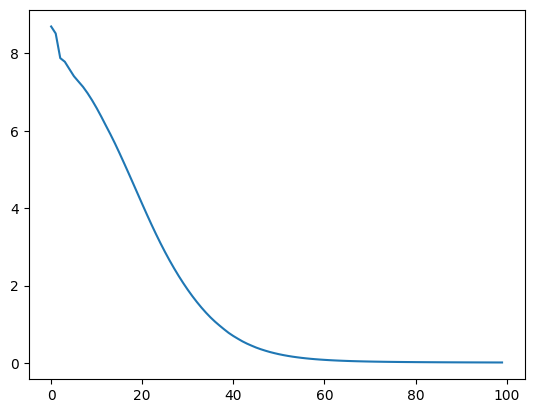

In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

torch.save(decoder.state_dict(), "savedModel.pt")
plt.figure()
plt.plot(all_losses)

**Generating the text**

In [63]:
def evaluate(prime_str='this process', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden().cuda()

    for p in range(predict_len):
        
        prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long).cuda()
        inp = prime_input[-2:] #last two words as input
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted word to string and use as next input
        predicted_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(top_i)]
        prime_str += " " + predicted_word
#         inp = torch.tensor(word_to_ix[predicted_word], dtype=torch.long)

    return prime_str

In [61]:
print(evaluate('this process', 40, temperature=1))

this process courted partner dennis graft reunification arctic source right harry january” right loan right appreciating infrastructure source minor preserves taxdodging right jackie regain mark porcupine battle wednesday creates bill’s business cap particularly change company repeals still small fuel escalating incumbent dreamers


In [62]:
print(evaluate('donald trump is a', 30, temperature=2))

donald trump is a pressed criticized tweet dinner diplomat 31 try tie giftwrapped although jumped salt puerto record thursday thursday rule wave step graham banking finding tuesday chuck record republican republican ford afterward us


In [64]:
print(evaluate('donald trump is a', 30, temperature=2))

donald trump is a exchange restriction loyal malpractice” clinched covering speech washington reuters murkowski asked republican presidential republican party trump candidate politician economy cost bond right alaska lawful allow officially itemizing ahead deportation two


In [50]:
"load in the model:"

'load in the model:'

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import unidecode
import random
import torch

train_df = pd.read_csv('data/True.csv')
author = train_df['text']
## clan dataset
text = list(author[:100])
def joinStrings(text):
    return ' '.join(string for string in text)
text = joinStrings(text)
# text = [item for sublist in author[:5].values for item in sublist]
len(text.split())

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop = set(nltk.corpus.stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = nltk.stem.wordnet.WordNetLemmatizer()
def clean(doc):
        stop_free = " ".join([i for i in doc.split() if i not in stop])
        punc_free = "".join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return normalized
test_sentence = clean(text).lower().split()

##N-Gram model
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
chunk_len=len(trigrams)
print(trigrams[:3])
vocab = set(test_sentence)
voc_len=len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}
inp=[]
tar=[]
for context, target in trigrams:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        inp.append(context_idxs)
        targ = torch.tensor([word_to_ix[target]], dtype=torch.long)
        tar.append(targ)

## RNN model:
import torch
import torch.nn as nn
from torch.autograd import Variable

hidden_size = 100
n_layers = 3
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers,batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrull\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mrull\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mrull\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


[(['washington', 'reuters'], 'the'), (['reuters', 'the'], 'head'), (['the', 'head'], 'conservative')]


In [52]:
def evaluate(prime_str='this process', predict_len=100, temperature=0.8):
    decoder = RNN(voc_len, hidden_size, voc_len, n_layers)
    decoder.load_state_dict(torch.load("savedModel.pt"))
    decoder.cuda()
    hidden = decoder.init_hidden().cuda()

    for p in range(predict_len):
        
        prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long).cuda()
        inp = prime_input[-2:] #last two words as input
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted word to string and use as next input
        predicted_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(top_i)]
        prime_str += " " + predicted_word
#         inp = torch.tensor(word_to_ix[predicted_word], dtype=torch.long)

    return prime_str

In [53]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [54]:
print(evaluate('trump is', 30, temperature=1))

RuntimeError: Error(s) in loading state_dict for RNN:
	Missing key(s) in state_dict: "gru.weight_ih_l2", "gru.weight_hh_l2", "gru.bias_ih_l2", "gru.bias_hh_l2". 